In [216]:
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon, LineString, Point
import numpy as np

In [217]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [218]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

In [219]:
def make_graph(point_1, point_2, obstacles, path = False):
    plt.scatter(point_1[0], point_1[1], c="blue")
    plt.scatter(point_2[0], point_2[1], c="blue")
    plt.plot([point_1[0], point_2[0]],[point_1[1], point_2[1]], c="gray")
    for obstacle_id, points in obstacles.items():
        start_x, start_y = points[0]
        end_x, end_y = points[1]
        plt.fill([start_x, end_x, end_x, start_x], [start_y, start_y, end_y, end_y],
                 label="Obstacle", alpha=0.7, color='red')
        
    if path:
        for i in range(len(path) - 1):
            plt.plot([path[i][0],path[i+1][0]],[path[i][1],path[i+1][1]],c="green")
    plt.grid(True)
    plt.show()

In [220]:
def create_polygon(obstacle):
    corner_1 = obstacle[0]
    corner_2 = obstacle[1]

    coords = [[corner_1[0],corner_1[1]],[corner_2[0],corner_1[1]],[corner_2[0],corner_2[1]],[corner_1[0], corner_2[1]],[corner_1[0], corner_1[1]]]
    obs_polygon = Polygon(coords)
    return obs_polygon


In [221]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [222]:
def dist(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

In [223]:
def create_shortest_path_1(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    for x in frange(0,6,0.5):
        for y in frange(0,6,0.5):
            flag = True
            point = (x, y)
            for obs_id, obs in obstacle_polygon.items():
                if Point(point).intersects(obs):
                    flag = False
                    break
            if flag:
                G.add_node(point)


    print(G.nodes())

    # Add edges between adjacent points (up, down, left, right)
    for node in G.nodes():
        x, y = node
        for dx, dy in [(0.5, 0), (-0.5, 0), (0, 0.5), (0, -0.5), (0.5, 0.5), (-0.5, -0.5), (-0.5, 0.5),(0.5, -0.5)]:
            neighbor = (x + dx, y + dy)
            if neighbor in G.nodes():
                G.add_edge(node, neighbor)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [224]:
def check_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            if len((line.intersection(obs)).coords) == 1:
                print("allow",line.intersection(obs))
                return False
            else:
                return True
    return False

In [225]:
def create_shortest_path_2(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
    route_line = LineString([point_1, point_2])

    intersections = []
    for obstacle_id, obstacle in obstacle_polygon.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(start)
                intersections.append(end)
    print(intersections)
    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for i in range(len(intersections)):
        point = intersections[i]
        pt_1 = (point[0] + 0.1, point[1])
        pt_2 = (point[0] - 0.1, point[1])
        pt_3 = (point[0], point[1] - 0.1)
        pt_4 = (point[0], point[1] + 0.1)
        pts = [pt_1, pt_2, pt_3, pt_4]

        for pt in pts:
            flag = True
            for obs_id, obs in obstacle_polygon.items():
                if Point(pt[0], pt[1]).intersects(obs):
                    flag = False
                    break
            if flag:
                G.add_node(pt)
    
    G.add_node(tuple(point_2))

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            if not check_obstacle(cur, next, obstacle_polygon):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

## Main

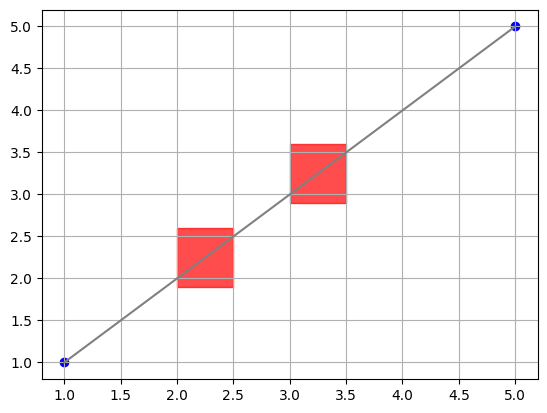

In [226]:
point_1 = [1,1]
point_2 = [5,5]

obstacles = {
    0 : [[2,1.9],[2.5,2.6]],
    1 : [[3,2.9],[3.5,3.6]]
}

make_graph(point_1, point_2, obstacles)

[(0, 0), (0, 0.5), (0, 1.0), (0, 1.5), (0, 2.0), (0, 2.5), (0, 3.0), (0, 3.5), (0, 4.0), (0, 4.5), (0, 5.0), (0, 5.5), (0.5, 0), (0.5, 0.5), (0.5, 1.0), (0.5, 1.5), (0.5, 2.0), (0.5, 2.5), (0.5, 3.0), (0.5, 3.5), (0.5, 4.0), (0.5, 4.5), (0.5, 5.0), (0.5, 5.5), (1.0, 0), (1.0, 0.5), (1.0, 1.0), (1.0, 1.5), (1.0, 2.0), (1.0, 2.5), (1.0, 3.0), (1.0, 3.5), (1.0, 4.0), (1.0, 4.5), (1.0, 5.0), (1.0, 5.5), (1.5, 0), (1.5, 0.5), (1.5, 1.0), (1.5, 1.5), (1.5, 2.0), (1.5, 2.5), (1.5, 3.0), (1.5, 3.5), (1.5, 4.0), (1.5, 4.5), (1.5, 5.0), (1.5, 5.5), (2.0, 0), (2.0, 0.5), (2.0, 1.0), (2.0, 1.5), (2.0, 3.0), (2.0, 3.5), (2.0, 4.0), (2.0, 4.5), (2.0, 5.0), (2.0, 5.5), (2.5, 0), (2.5, 0.5), (2.5, 1.0), (2.5, 1.5), (2.5, 3.0), (2.5, 3.5), (2.5, 4.0), (2.5, 4.5), (2.5, 5.0), (2.5, 5.5), (3.0, 0), (3.0, 0.5), (3.0, 1.0), (3.0, 1.5), (3.0, 2.0), (3.0, 2.5), (3.0, 4.0), (3.0, 4.5), (3.0, 5.0), (3.0, 5.5), (3.5, 0), (3.5, 0.5), (3.5, 1.0), (3.5, 1.5), (3.5, 2.0), (3.5, 2.5), (3.5, 4.0), (3.5, 4.5), (3.5, 5

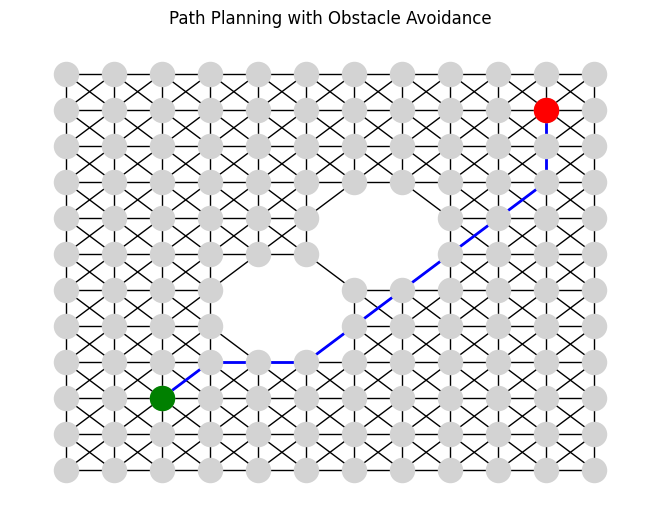

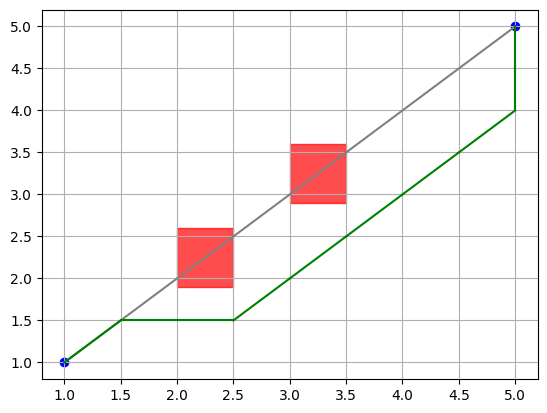

In [227]:
path_1 = create_shortest_path_1(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_1)

[(2.5, 1.9), (2.5, 2.6), (2.0, 2.6), (2.0, 1.9), (3.5, 2.9), (3.5, 3.6), (3.0, 3.6), (3.0, 2.9)]
Path cost : 3


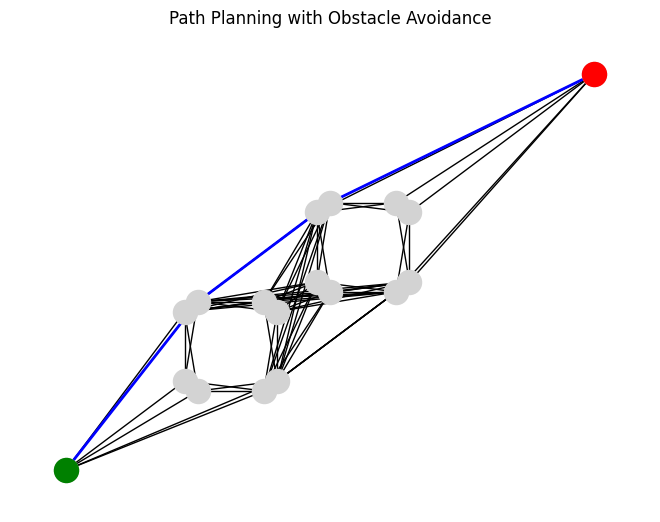

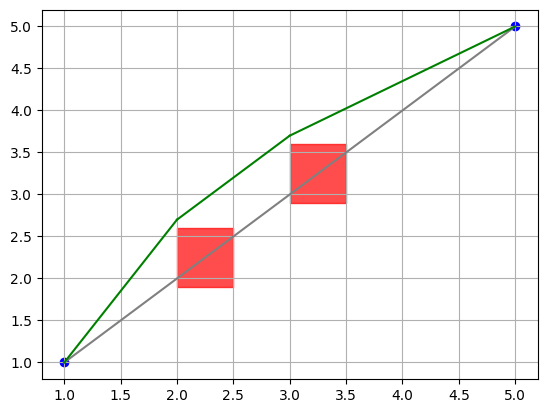

Distance 5.77189394308001


In [228]:
path_2 = create_shortest_path_2(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_2)
print("Distance",total_dist(path_2))

[(2.5, 1.9), (2.5, 2.6), (2.0, 2.6), (2.0, 1.9), (3.5, 2.9), (3.5, 3.6), (3.0, 3.6), (3.0, 2.9)]
Path cost : 3


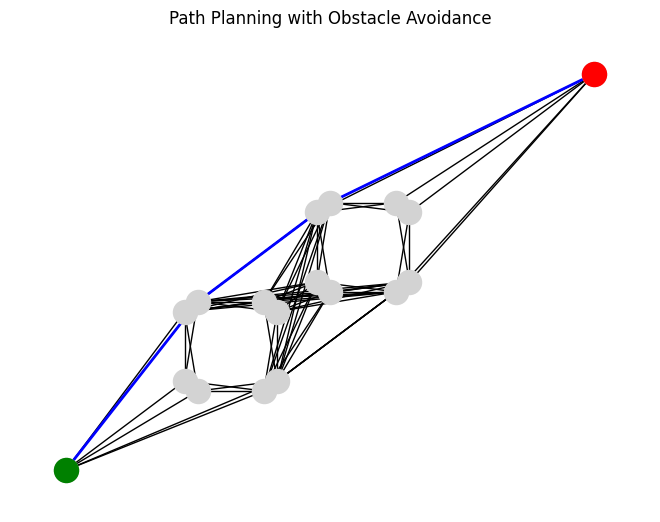

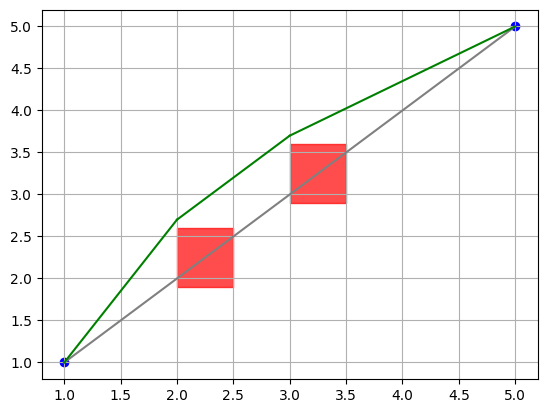

In [229]:
path_3 = create_shortest_path_2(point_1, point_2, obstacles)
make_graph(point_1, point_2, obstacles, path = path_3)

## DP creation in cluster projects

In [230]:
from k_means_constrained import KMeansConstrained
import numpy as np
import random

def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

In [231]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

In [232]:
def clusters_plot(clusters, centroids):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.title("After Clustering")
    plt.show()

In [233]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [234]:
from itertools import permutations

def tsp(cluster):
    paths = list(permutations(cluster))
    distance = []
    for path in paths:
        path = list(path)
        dist = 0
        for i in range(len(path)-1):
            dist += calculate_distance(path[i], path[i+1])
        distance.append(dist)
    
    ans_route = paths[np.argmin(distance)]
    ans_distance = distance[np.argmin(distance)]

    return [ans_route[0], ans_route[-1]],ans_route

Main

In [235]:
n = 20
k = 5

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
delivery_loc = create_locations(x, y, n)

centroids, clusters = KMeans(delivery_loc, n, k)

clusters

{0: [[22.6081, 88.4377],
  [22.6051, 88.435],
  [22.6074, 88.4434],
  [22.6121, 88.4315],
  [22.6038, 88.4327]],
 1: [[22.6082, 88.4054],
  [22.5829, 88.4015],
  [22.5734, 88.4063],
  [22.5986, 88.4075],
  [22.5933, 88.406]],
 2: [[22.5932, 88.4359],
  [22.576, 88.4529],
  [22.5735, 88.4654],
  [22.6021, 88.4554],
  [22.5987, 88.4597]],
 3: [[22.5822, 88.4353],
  [22.5808, 88.4119],
  [22.5998, 88.4233],
  [22.5786, 88.4334],
  [22.5873, 88.4337]]}

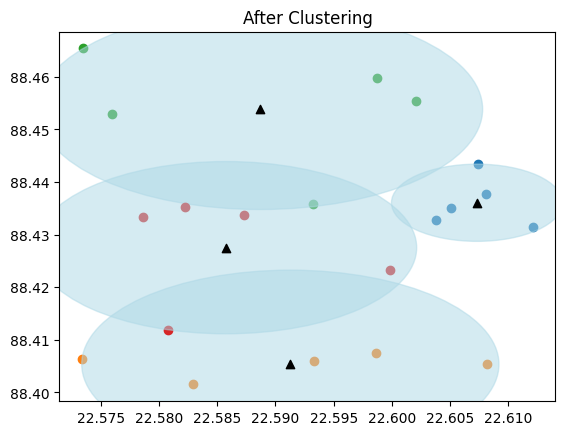

In [236]:
clusters_plot(clusters, centroids)

In [237]:
longest_points = []

for cls_id, cluster in clusters.items():
    points, new_cluster = tsp(cluster)
    clusters[cls_id] = new_cluster
    longest_points.append(points[0])
    longest_points.append(points[1])

print(clusters)
print(longest_points)

{0: ([22.6074, 88.4434], [22.6081, 88.4377], [22.6051, 88.435], [22.6038, 88.4327], [22.6121, 88.4315]), 1: ([22.6082, 88.4054], [22.5986, 88.4075], [22.5933, 88.406], [22.5829, 88.4015], [22.5734, 88.4063]), 2: ([22.5932, 88.4359], [22.6021, 88.4554], [22.5987, 88.4597], [22.576, 88.4529], [22.5735, 88.4654]), 3: ([22.5808, 88.4119], [22.5786, 88.4334], [22.5822, 88.4353], [22.5873, 88.4337], [22.5998, 88.4233])}
[[22.6074, 88.4434], [22.6121, 88.4315], [22.6082, 88.4054], [22.5734, 88.4063], [22.5932, 88.4359], [22.5735, 88.4654], [22.5808, 88.4119], [22.5998, 88.4233]]


## Curve line project

In [238]:
from shapelysmooth import catmull_rom_smooth

In [239]:
def check_for_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            # if len((line.intersection(obs)).coords) > 1:
            return True
    return False

In [240]:
def create_shortest_path_3(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
    route_line = LineString([point_1, point_2])

    intersections = []
    for obstacle_id, obstacle in obstacle_polygon.items():
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])
    print(intersections)
    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))

    G.add_node(tuple(point_2))
    
    # create new polygon
    for obs_id, obstacle in obstacle_polygon.items():
        x_min,y_min,x_max,y_max = obstacle.bounds
        polygon = obstacle.from_bounds(x_min+0.01, y_min+0.01, x_max-0.01, y_max-0.01)
        obstacle_polygon[obs_id] = polygon

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            if not check_for_obstacle(cur, next, obstacle_polygon):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=dist)
    print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=dist))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [241]:
def create_shortest_path_curve(path):
    print(path)
    answer = catmull_rom_smooth(LineString(path), 0.5, 10).coords
    print(answer)
    return answer

LINESTRING (1 1, 1.0097511023015642 1.0368103452136437, 1.056167811688398 1.1246295914583948, 1.133021266978394 1.2537618720797836, 1.234082606989447 1.4145113204233426, 1.3531229705394499 1.5971820698346018, 1.4839134964462968 1.792078253659093, 1.6202253235278814 1.9895040052423465, 1.7558295906020978 2.1797634579298952, 1.8844974364868394 2.353160745067269, 2 2.5, 2.093703373626264 2.612004519007674, 2.1862017378278873 2.717991911498329, 2.278471690003589 2.819218223331876, 2.371489827552087 2.916939500368221, 2.4662327478720982 3.012411788467276, 2.563677048362343 3.106891133488949, 2.664799326421537 3.201633581293148, 2.770576179448399 3.2978951777397834, 2.8819842048416473 3.3969319686887647, 3 3.5, 3.1657409974027364 3.6371778624248234, 3.3394121191636086 3.769973126677602, 3.5208944855314215 3.9010977785374497, 3.710069216754979 4.033263803783484, 3.906817433083086 4.169183188194817, 4.111020254764545 4.3115679175505655, 4.322558802048162 4.463129977629842, 4.541314195182741 4.

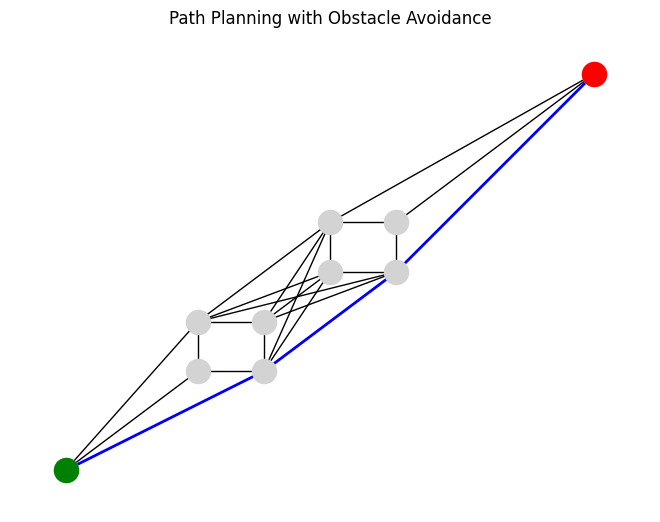

[(1, 1), (2.5, 2.0), (3.5, 3.0), (5, 5)]


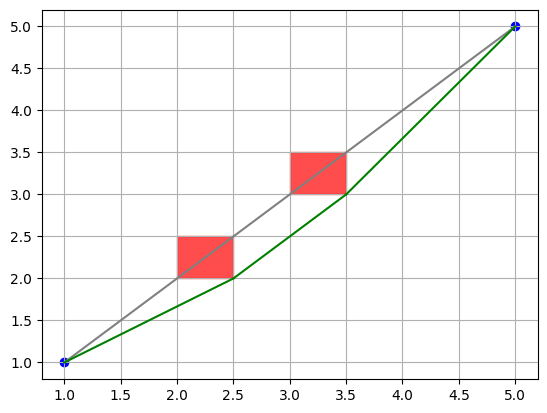

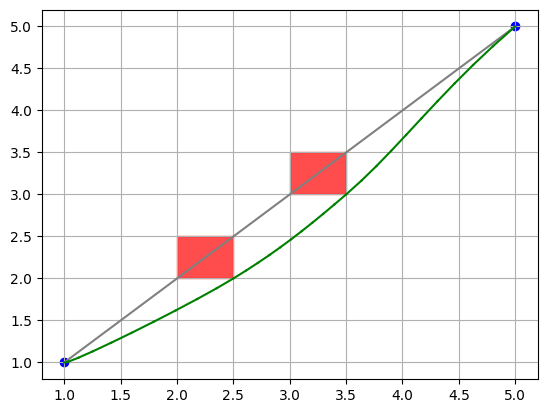

Distance in line : 5.71698920010509
Distance in curve : 5.724119519319855


In [242]:
output = catmull_rom_smooth(LineString([[1,1],[2, 2.5],[3, 3.5],[5,5]]), 0.5, 10)

print(output)

point_1 = [1,1]
point_2 = [5,5]

obstacles = {
    0 : [[2,2],[2.5,2.5]],
    1 : [[3,3],[3.5,3.5]]
}
path = create_shortest_path_3(point_1, point_2, obstacles)
path_2 = create_shortest_path_curve(path)
make_graph(point_1, point_2, obstacles, path)
make_graph(point_1, point_2, obstacles, path_2)
print("Distance in line :",total_dist(path))
print("Distance in curve :",total_dist(path_2))